# Che 116 Final Project - Modeling COVID-19 Spread to Estimate the True Number of Cases
## Robert Sheiman
### 5/1/2020

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as ss
import scipy.optimize as opt
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

## Introduction
This project notebook will walk readers through the process of gathering New York State COVID-19 data, making an epidemiological model, and fitting the model to the data. This will transform the model an accurate model of NY state, allowing one to forecast cases, estimate lockdown end dates, or share data visually.

### Raw COVID Data
Raw testing data from the state of new york government $^{[1]}$. It contains positive cases over time for each county. New positive cases per day over time will be matched to a graph model of COVID.

In [2]:
# csv downloaded from 
raw_data = pd.read_csv('NYS_COVID19.csv')
print(raw_data)

       Test Date        County  New Positives  Cumulative Number of Positives  \
0     04/29/2020        Albany             98                            1165   
1     04/29/2020      Allegany              0                              35   
2     04/29/2020         Bronx            644                           37244   
3     04/29/2020        Broome             11                             284   
4     04/29/2020   Cattaraugus              0                              47   
5     04/29/2020        Cayuga              0                              48   
6     04/29/2020    Chautauqua              2                              33   
7     04/29/2020       Chemung              3                             122   
8     04/29/2020      Chenango              2                              98   
9     04/29/2020       Clinton              0                              59   
10    04/29/2020      Columbia              5                             170   
11    04/29/2020      Cortla

### Population Data

Let's just focus on large counties. To do that we will need population. It'll be useful later too. Starting with a Kaggle dataset, everything except county name and population can be removed $^{[2]}$.

In [3]:
county_pops = pd.read_csv('NY_population.csv')

county_pops = county_pops.drop(['Program Type', 'FIPS Code'], axis=1)
county_pops = county_pops.query('Year >= 2018')
county_pops = county_pops.drop(['Year'], axis=1)
county_pops = county_pops.sort_values('Population', ascending=False)

print(county_pops[0:10])

             Geography  Population
0       New York State    19542209
24        Kings County     2582830
41       Queens County     2278906
31     New York County     1628701
52      Suffolk County     1481093
3         Bronx County     1432132
30       Nassau County     1358343
60  Westchester County      967612
15         Erie County      919719
28       Monroe County      742474


### Narrow Down the Data for the Model
To make the model reasonably fast and straightforward to program, let's focus on 5 counties. Let's also convert to numpy arrays to make life easier.

In [4]:

array = ['Monroe County', 'Onondaga County',  'Queens County', 'Schenectady County',  'Erie County']
county_pops = county_pops.loc[county_pops['Geography'].isin(array)].to_numpy()

array1 = ['Monroe', 'Onondaga',  'Queens', 'Schenectady',  'Erie']
data = raw_data.loc[raw_data['County'].isin(array1)].to_numpy()

print(county_pops, data)

[['Queens County' 2278906]
 ['Erie County' 919719]
 ['Monroe County' 742474]
 ['Onondaga County' 461809]
 ['Schenectady County' 155350]] [['04/29/2020' 'Erie' 123 3319 885 16104]
 ['04/29/2020' 'Monroe' 37 1441 469 14015]
 ['04/29/2020' 'Onondaga' 50 832 343 10667]
 ...
 ['03/02/2020' 'Onondaga' 0 0 0 0]
 ['03/02/2020' 'Queens' 0 0 0 0]
 ['03/02/2020' 'Schenectady' 0 0 0 0]]


### Dealing with Dates
I'll convert each date string into days since 3/2 

In [5]:
for dp in data: #earliest date is 03/02, so we will convert the date to days since 3/2
    nums = [int(i) for i in dp[0].split('/')]
    if nums[0] == 3:
        dp[0] = nums[1]-2
    elif nums[0] == 4:
        dp[0] = nums[1]+31-2

print(data)

[[58 'Erie' 123 3319 885 16104]
 [58 'Monroe' 37 1441 469 14015]
 [58 'Onondaga' 50 832 343 10667]
 ...
 [0 'Onondaga' 0 0 0 0]
 [0 'Queens' 0 0 0 0]
 [0 'Schenectady' 0 0 0 0]]


### Reshaping the Data
To make this data easy to work with, we want both county populations and coronavirus cases in one array. We will make a length-5 array where each element is a list containing:

(County Name, New coronavirus cases over time, Population)

In [6]:
Monroe = 0
Onondaga = 1
Queens = 2
Schenectady = 3
Erie = 4

dat = np.zeros(5, dtype='object, 59int32, int32')
dat[Monroe][0] = 'Monroe'
dat[Onondaga][0] = 'Onondaga'
dat[Queens][0] = 'Queens'
dat[Schenectady][0] = 'Schenectady'
dat[Erie][0] = 'Erie'

for dp in data:
    if dp[1] == 'Erie':
        dat[Erie][1][dp[0]] = dp[2] # 3 is the number of cumultaive positives
    if dp[1] == 'Monroe':
        dat[Monroe][1][dp[0]] = dp[2]
    if dp[1] == 'Onondaga':
        dat[Onondaga][1][dp[0]] = dp[2]
    if dp[1] == 'Queens':
        dat[Queens][1][dp[0]] = dp[2]
    if dp[1] == 'Schenectady':
        dat[Schenectady][1][dp[0]] = dp[2]
        
for pop in county_pops:
    if pop[0].split(' ')[0] == 'Erie':
        dat[Erie][2] = pop[1]
    if pop[0].split(' ')[0] == 'Monroe':
        dat[Monroe][2] = pop[1]
    if pop[0].split(' ')[0] == 'Onondaga':
        dat[Onondaga][2] = pop[1]
    if pop[0].split(' ')[0] == 'Queens':
        dat[Queens][2] = pop[1]
    if pop[0].split(' ')[0] == 'Schenectady':
        dat[Schenectady][2] = pop[1]
        
print(dat)

[('Monroe', [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    1,    0,    7,    1,    4,   13,    5,   10,   15,   19,   20,   22,   21,   21,   32,   27,   23,   50,   57,   71,   44,   48,   36,   26,   22,   55,   47,   44,   25,   31,   25,   27,   34,   48,   43,   33,   24,   22,   16,   42,   40,   47,   86,   31,   15,   40,   33,   37],  742474)
 ('Onondaga', [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    1,    0,    3,    3,    9,   12,   23,    8,    5,   18,   32,   14,   23,   28,   14,   23,   17,   18,   10,    6,    3,   64,   12,   11,   11,   11,   17,   19,   15,   18,   13,   21,    9,    6,   11,    5,   12,   74,   39,   25,   28,   34,   16,   40,   50],  461809)
 ('Queens', [   0,    0,    0,    1,    1,    0,    1,    0,    4,    5,   15,   30,   18,   49,   38,  123,  336,  519,  491,  843, 1152,  839, 1010, 1238, 1324, 1238, 1136, 1258, 2022, 1211, 1366, 1899, 1947, 1322, 1697, 1707, 1408, 1504, 155

### Visualize Data
Our data preprocessing paid off! It made plotting this data incredibly easy!

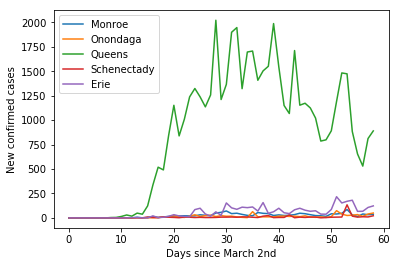

In [7]:
for county in dat:
    plt.plot(np.arange(59), np.array(county[1]), label=county[0])

plt.xlabel('Days since March 2nd')
plt.ylabel('New confirmed cases')
plt.legend()
plt.show()

### Defining the Model
Networkx is a Python library for making graphs. Each node will hold information about the county population, susceptible people, infected people, and removed (dead/recovered) people. Edges will be means for populations to travel between counties. The model will start with 2 infected people per county and everyone else in the whole population being susceptible. We will also define coordinates for each county for better visualization. As for travelling, each county will be connected to adjacent counties, except for Queens which will connect to all of them. This should capture the effect of NYC as a 'hotspot'.

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


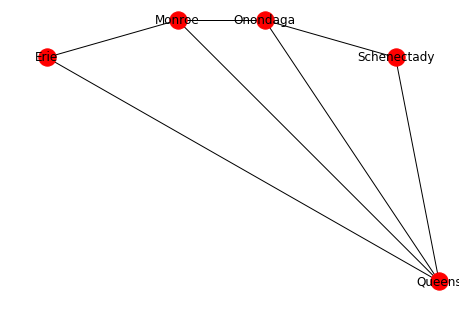

In [8]:
import networkx as nx

model = nx.Graph()
positions = {'Queens': (50, 0), 'Schenectady': (45, 30), 'Erie': (5, 30), 'Onondaga': (30, 35), 'Monroe': (20, 35)}

def set_graph():
    for county in dat:
        model.add_node(county[0])
        model.nodes[county[0]]['infected'] = 2
        model.nodes[county[0]]['susceptible'] = county[2]-2
        model.nodes[county[0]]['removed'] = 0
        model.nodes[county[0]]['pop'] = county[2]

    model.add_edge('Erie', 'Monroe')
    model.add_edge('Monroe', 'Onondaga')
    model.add_edge('Onondaga', 'Schenectady')
    model.add_edge('Schenectady', 'Queens')
    model.add_edge('Monroe', 'Queens')
    model.add_edge('Erie', 'Queens')
    model.add_edge('Onondaga', 'Queens')

set_graph()
nx.draw(model, positions, with_labels=True)

### The infection loop
The infection loop loops through n number of days, each day adjusting the properties of each node. Each day some people will travel, some infected people will spread the virus, and some people will recover. 

In [9]:
def infection_loop(args, days, cumulative=False): #args = (p(travel), betta, gamma, p(test))
    
    set_graph()
    cases = np.zeros(days)
    by_county = np.zeros((days, len(model.nodes)))
    
    for day in range(days):
        #print('S', model.nodes['Queens']['susceptible'])
        #print('I', model.nodes['Queens']['infected'])
        #print('R', model.nodes['Queens']['removed'])
        for edge in model.edges: #travel phase
            
            #susceptible travellers
            UtoV = int(model.nodes[edge[0]]['susceptible']*args[0])
            model.nodes[edge[1]]['susceptible'] += UtoV
            model.nodes[edge[0]]['susceptible'] -= UtoV
            
            VtoU = int(model.nodes[edge[1]]['susceptible']*args[0])
            model.nodes[edge[0]]['susceptible'] += VtoU
            model.nodes[edge[1]]['susceptible'] -= VtoU
            
            #infected travellers
            UtoV = int(model.nodes[edge[0]]['infected']*args[0])
            model.nodes[edge[1]]['infected'] += UtoV
            model.nodes[edge[0]]['infected'] -= UtoV
            
            VtoU = int(model.nodes[edge[1]]['infected']*args[0])
            model.nodes[edge[0]]['infected'] += VtoU
            model.nodes[edge[1]]['infected'] -= VtoU
            
            #ignore removed population
        
        for i, node in enumerate(model.nodes): #infection + removal
            
            term1 = int(args[1]*model.nodes[node]['susceptible']*model.nodes[node]['infected']/(model.nodes[node]['pop']))+np.random.random() #Beta*S*I/N
            term2 = int(args[2]*model.nodes[node]['infected'])
                                                                                            
            #Some of the newly infected people get tested
            cases[day] += int((term1-term2)*args[3])
            
            by_county[day][i] = model.nodes[node]['infected']

            model.nodes[node]['infected'] += term1-term2
            model.nodes[node]['susceptible'] -= term1
            model.nodes[node]['removed'] += term2
        
        if cumulative:
            cases[day] = np.sum([model.nodes[n]['infected'] for n in model.nodes])
        
    return cases, by_county

## How the Model Works
The infection loop is the heart of the model. It has two phases
#### The Travelling Phase
In this phase, the model loops through each 'road' in the graph, and susceptible/infected people travel. The number of people who travel is a certain percent, $\alpha$, of the population. 
#### The Infection + Removal Phase
For each county, the model 'infects' a certain subset of the susceptible population. To do that, we must define the number of susceptible persons becoming infected as:
$$ S->I = \beta  \frac{SI}{N} + random(0, 1) $$
Where $\beta$ is another optimizable parameter, and N is total population. This way, it is proportional to both susceptible population and infected population. It also cannot be greater than the susceptible population. The random number between 0 and 1 is because the model works in integers (number of people). For small $\beta$ the S->I number can stay stuck at 0 without this term.

Similarly, the model removes a certain amount of people from the infected population, moving them to the removed population. This is analogous to either recovery or death. This number is simply $\gamma I$ where $\gamma$ is another parameter to tweak.

This logic used in this phase is based on the SIR model from 1927, by W. O. Kermack and A. G. McKendrick $^{[3]}$. 

#### Testing
Lastly, the model assumes a certain percent of infectious people will show symptoms and get tested. This happens in the infection phase, when susceptible people become infected. This percentage is an optimizable parameter $\delta$.

### Time to Test it Out!

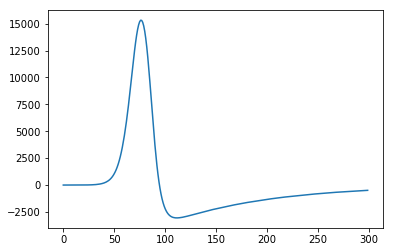

In [10]:
args0 = [0.00, 0.2, 0.01, 0.1] #our parameters to optimize, [alpha, beta, gamma, delta]

result = infection_loop(args0, 300)[0]

plt.plot(np.arange(len(result)), result)
plt.show()

### Fitting the Model to Data
Now, an error function must be defined that compares the infection loop output to the real data. Then we can use scipy.optimize to adjust the infection loop arguments and minimize error. The error function used is sum of squared residuals, making this ordinary least squares regression.

The real COVID case data is padded by a month because the infection loop takes a while for infection to spread no matter the $\beta$ value. This also has the nice effect of making the x-axis the number of days since February 1st.

#### Warning: This cell takes ~1 min to run! 

The optimizer never really converges to an excellent solution. Instead we will fit it using a fixed 200 iterations, and assume the result will be good. 'Good' of course is very subjective, but assume the resulting graph will be enough to know whether or not the model fit is good.

If you run the cell multiple times, you'll notice that sometimes the model cases spike twice, or end with the cases still rising! That means there are enough susceptible in the population for the virus to have a second wave!

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


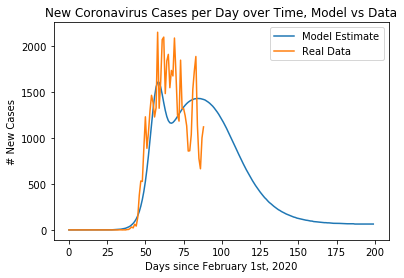

This model assumes 1.9857% percent of infected people get tested per day!
Best parameters: [ 0.01501944  0.06926337 -0.00065381  0.01985683]


In [20]:
padding = 30
cases_real = np.sum(county[1] for county in dat)
cases_real = np.concatenate((np.zeros(padding), cases_real))

def error(args):
    cases_estimate = np.array(infection_loop(args, 59+padding)[0])
    return np.sum(np.square(cases_estimate-cases_real)) #sum of square residual

#args = (p(travel), p(infect), p(remove), p(test))
result = opt.minimize(error, x0=[0.01, 0.2, 0.05, 0.01], method='Nelder-Mead', options={'maxiter': 200}, bounds=[(0, 0.5), (0, 0.99), (0, 0.5), (0, 0.5)])
best_args = result.x

model_cases = infection_loop(best_args, 200)[0]
plt.plot(np.arange(len(model_cases)), model_cases, label='Model Estimate')
plt.plot(np.arange(len(cases_real)), cases_real, label='Real Data')
plt.ylabel('# New Cases')
plt.xlabel('Days since February 1st, 2020')
plt.title('New Coronavirus Cases per Day over Time, Model vs Data')
plt.legend()
plt.show()

print('This model assumes {0:.4%} percent of infected people get tested per day!'.format(best_args[3]))
print('Best parameters: {}'.format(best_args))

Once the trend looks good, run an infection loop with these best parameters, except this time set cumulative=True, which will assume every infected person is tested and report total cases instead of new daily cases.

Peak cases:  5245720.878494757


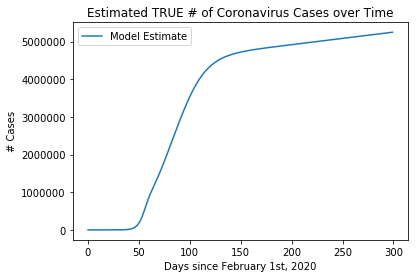

In [22]:
model_cases = infection_loop(best_args, 300, cumulative=True)[0]

print('Peak cases: ', np.max(model_cases))

plt.plot(np.arange(len(model_cases)), model_cases, label='Model Estimate')
plt.ylabel('# Cases')
plt.xlabel('Days since February 1st, 2020')
plt.title('Estimated TRUE # of Coronavirus Cases over Time')
plt.legend()
plt.show()

So our model predicts the true peak to be nearly 3-5 million cases assuming the trend continues downward (changes each time you run the optimization). That's around 15-25% of the NY population, with the number falling by June. I hope so! Another possibility is much more cases if the trend changes. Again, running the optimization cell a few times will yield very different result!

We can also visualize the spread thanks to networkx. Here is a NY map of coronavirus cases where county size is proportional to infection count. Shown is the state at day 10, day 50, and day 100 (days since February 1st):

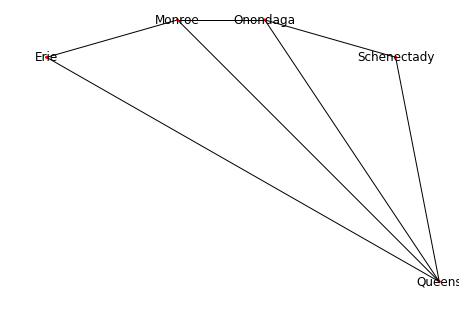

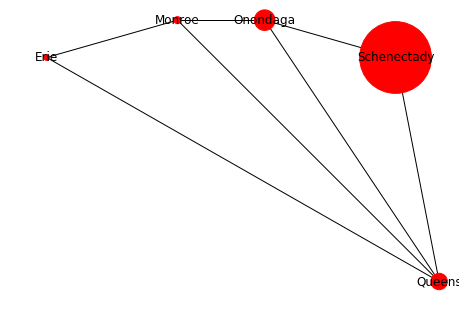

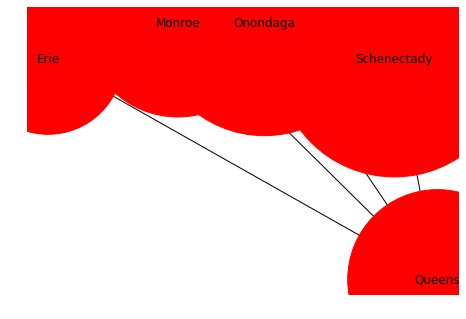

In [13]:
sizes0 = infection_loop(best_args, 300)[1][10]/2
sizes1 = infection_loop(best_args, 300)[1][50]/10
sizes2 = infection_loop(best_args, 300)[1][100]/20
nx.draw(model, positions, node_size = sizes0, with_labels=True)
plt.show()
nx.draw(model, positions, node_size = sizes1, with_labels=True)
plt.show()
nx.draw(model, positions, node_size = sizes2, with_labels=True)   
plt.show()

Using the matplotlib imsave function, one could even animate the results of the model.

### Result Discussion
The model predicts that only 2.8% of people who are positive get tested. That makes the true number of cases $1/0.028=35.7$ times higher than the true number of cases. One article $^{[4]}$ states that researchers predict the true number of cases to be anywhere from 5-100 times higher than the number of positive tests. This model falls well within that range, meaning it could be a fairly accurate view of coronavirus. Still, the simplicity of our model makes it questionable. After all, the model appeared to minimize the amount of travellers in the simulation, so it may have more or less just isolated Queens (by far the largest population) and tried to get the cases there to match the data. The real world is incredibly complex, and no model will be perfect, but even simple epidemiological models can help forecast the future.

The necessity for more complex models is very obvious. This epidemiology model is one of the most basic, being from 1927. The implementation of it into a computer simulation, however, is relativley novel. The 'computerization,' if that is a word, is very useful for visualizing and sharing results. This project demonstrates the relative ease, accuracy, and sharing ability of computational epidemiology models.

### References

[1] New York State Department of Health. “New York State Statewide COVID-19 Testing: Health Data NY.” New York State Statewide COVID-19 Testing | Health Data NY, 1 May 2020, health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e.

[2] State of New York. “New York State Annual Population Estimates.” Kaggle, 3 Dec. 2019, www.kaggle.com/new-york-state/new-york-state-annual-population-estimates.

[3] Kermack, W. O.; McKendrick, A. G. (1927). "A Contribution to the Mathematical Theory of Epidemics". Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences.

[4] Canning, David, and David E. Bloom. “How Widespread Is Coronavirus in New York? We Need to Know.” World Economic Forum, 31 Mar. 2020, www.weforum.org/agenda/2020/03/how-widespread-coronavirus-new-york/.
